Running Model-43: 4960it [00:00, 7294.12it/s]<?, ?it/s]
Running Model-43: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-43...


Running Model-43: 30it [00:00, 4997.19it/s]            


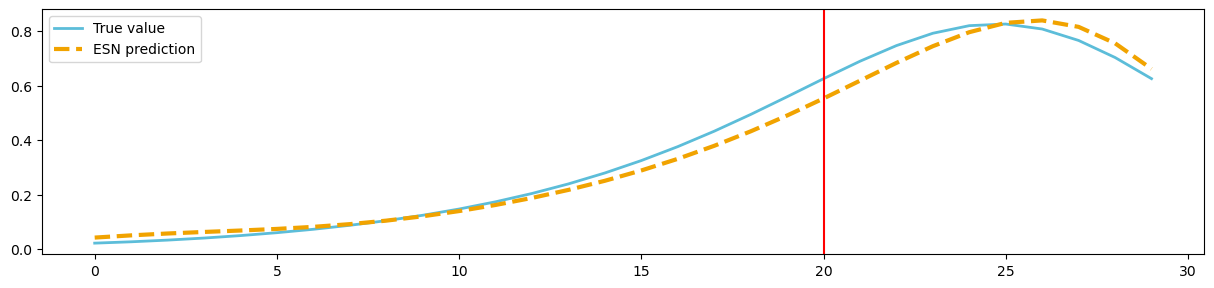

In [102]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp

length = 5000
train = 4960
forecast = 10

###ПОДГОТОВКА ДАННЫХ
#9
import warnings
from nolitsa import data
dt = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]


x = data.lorenz(length=length, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
import copy
time = copy.deepcopy(x) 
X = time[:,0] 
X = X.reshape(length,1) 
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1 
    
def results(y_pred, y_test):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    #ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    #ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")

    ax.plot(np.arange(len(y_test)), y_test, lw=2, label="True value", color="#5cbdd9")
    ax.plot(np.arange(len(y_pred)), y_pred, lw=3, label="ESN prediction", color="#f1a300", linestyle="--")
    ax.axvline(x=len(y_test)-forecast, color="red")  # Add vertical line
    ax.legend()
    plt.show()
    
###HERE0
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=forecast)

X_train1, y_train1 = x[:train], y[:train]
X_test1, y_test1 = x[train:], y[train:]

#Первый тестовый набор параметров 
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1)
results(y_pred1, y_test1)
###HERE1

In [103]:
tmp = np.full(len(y_train1), None)
y_pred1_extended = np.concatenate([tmp.reshape(len(y_train1), 1), y_pred1])

In [104]:
def results():
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    #ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    #ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")
    
    ax.plot(np.arange(len(np.concatenate([y_train1, y_test1]))), np.concatenate([y_train1, y_test1]), lw=2, color="#5cbdd9")
    ax.plot(np.arange(len(np.concatenate([y_train1, y_test1]))), y_pred1_extended, lw=3, color="#f1a300", linestyle="--")
    #ax.axvline(x=len(y_test)-forecast, color="red")  # Add vertical line
    #ax.legend()
    plt.show()



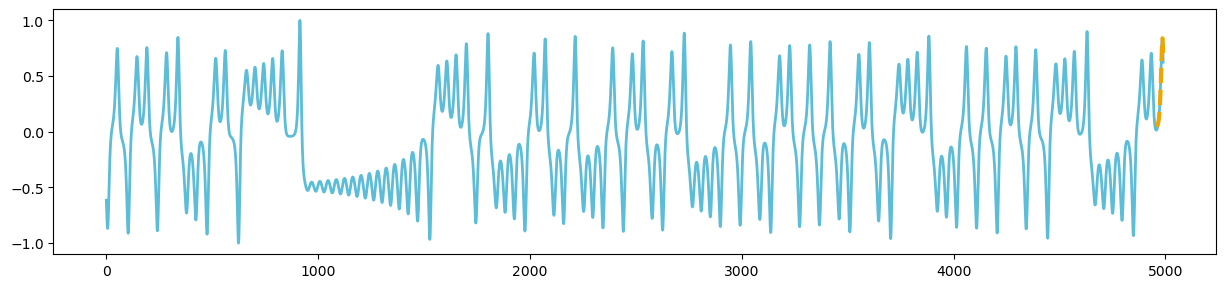

In [105]:
results()

In [106]:
y_test1.shape

(30, 1)